In [1]:
import numpy as np
import random as rd
import shap
from math import log
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as pl

C:\Users\86185\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None,fontsize=20,title_fontsize=22, axis_title_fontsize=18):
    # 利用sklearn中的函数生成混淆矩阵并归一化
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)  # 生成混淆矩阵
    print(cm,"\n")
    epsilon = 1e-7
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + epsilon)  # 归一化
    print(cm,"\n")
    cm[np.isnan(cm)] = 1
    print(cm)

    cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
    fig, ax = plt.subplots(figsize=(20,10))

    im=pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'),vmin=0.0)
    cbar = plt.colorbar(im, ax=ax)  # 获取颜色渐进条对象
    cbar.ax.tick_params(labelsize=axis_title_fontsize)
    # pl.colorbar()  # 绘制图例

    # 图像标题
    if title is not None:
        pl.title(title)
        pl.title(title, fontsize=title_fontsize)
    # 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    pl.xticks(num_local, axis_labels, rotation=45,fontsize=axis_title_fontsize)  # 将标签印在x轴坐标上， 并倾斜45度
    pl.yticks(num_local, axis_labels,fontsize=axis_title_fontsize)  # 将标签印在y轴坐标上
    pl.ylabel('True label',fontsize=axis_title_fontsize)
    pl.xlabel('Predicted label',fontsize=axis_title_fontsize)

    # 为底部的标签留出更多的空间
    fig.subplots_adjust(bottom=0.4, right=0.85) 

    # 调整子图间距以适应坐标轴标签
    plt.tight_layout()
    
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            percentage = cm[i][j] * 100
        # 检查百分比是否大于0以避免在文本中显示0%
            if percentage >= 0:
            # 格式化为固定的小数点后两位的百分比字符串
               percentage_str = "{:.0f}%".format(percentage)
            # 根据阈值设置文本颜色
               color = "white" if cm[i][j] > thresh else "black"
            # 在混淆矩阵的相应位置添加文本
               plt.text(j, i, percentage_str,
                        ha="center", va="center",
                        color=color,fontsize=fontsize)
    
    # 保存为矢量图
    plt.savefig("SVM_confusion_matrix.svg", format="svg")  # 保存为SVG格式的矢量图
    # 显示
    pl.show()


In [3]:
def count_nber(nb,arr):
    return sum(element == nb for element in arr)

In [4]:
def cross_val_class_score(clf, X, y, cv=2):
    kfold = StratifiedKFold(n_splits=cv).split(X, y)
    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])  # 使用训练数据拟合模型
        # y_test = y[test]
        y_pred = clf.predict(X[test])
        # 计算混淆矩阵，通过混淆矩阵找出对于每一个折，分类是0或者1的概率
        class_acc = cmat.diagonal() / cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy {:s}'.format(k + 1, str(class_acc)))
    return np.array(class_accuracy)

In [5]:
def plot_feature_importances(feature_importances, title, feature_names):
    # Normalize the importance values
    feature_importances = 100.0 * (feature_importances / max(feature_importances))

    # Sort the values and flip them
    index_sorted = np.flipud(np.argsort(feature_importances))
    
    print(index_sorted,type(index_sorted))
    # Arrange the X ticks
    pos = np.arange(index_sorted.shape[0]) + 0.5
    # Plot the bar graph
    plt.figure(figsize=(25,8),dpi=80)
    plt.bar(pos, feature_importances[index_sorted], align='center')
    print(feature_names[index_sorted].values.tolist())
    plt.xticks(pos, feature_names[index_sorted].values.tolist()[0]) 
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()

In [6]:
data = pd.read_excel('T-VMS.xlsx')
display(data)

sm = SMOTE(random_state=40)
X_res, y_res = sm.fit_resample(data.iloc[:,:-1],data.iloc[:,-1])
display(X_res,y_res)
X_train, X_test, Y_train, Y_test = train_test_split(X_res,  y_res,
                                                    test_size=0.3, random_state=30, stratify = y_res)

mm = preprocessing.MinMaxScaler()
ss = preprocessing.StandardScaler()
# 获取数据源
X_train = pd.DataFrame(ss.fit_transform(X_train))
X_test = pd.DataFrame(ss.fit_transform(X_test))
# 归一化处理

display(X_train, X_test, Y_train, Y_test)
np.random.seed(1)
clf = RandomForestClassifier(n_estimators=400)
# clf.fit(X, y)
max_depths: list[int] = [3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 19]
train_scores, test_scores = validation_curve(
    estimator=clf,
    X=X_train,
    y=Y_train,
    param_name='max_depth',
    param_range=max_depths,
    cv=5
)
train_scores1 = train_scores.flatten()
test_scores1 = test_scores.flatten()
scores = np.vstack((train_scores1, test_scores1)).T
scores


,SiO2,TiO2,Al2O3,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,...,Yb,Lu,Hf,Ta,Ga,Gd,Pb,Th,U,Deposit Type
0,33.34,0.840,11.48,5.76,0.11,3.7400,22.23,0.89,2.51,0.100,...,1.400000,0.230000,1.000,0.250000,12.00,2.410000,2.500000,0.40,0.550,1
1,75.80,0.140,12.05,2.47,0.02,2.7400,0.18,1.39,2.70,0.005,...,4.180000,0.630000,6.900,1.600000,17.90,7.950000,2.500000,22.60,6.240,1
2,56.05,2.060,14.60,13.60,0.42,4.2400,3.44,5.47,0.03,0.230,...,4.293498,0.722036,17.400,1.678045,87.90,7.192047,144.700000,0.25,0.250,3
3,78.17,0.230,11.98,0.70,0.02,4.1923,0.51,5.38,1.42,0.040,...,6.150000,0.872000,10.700,1.420000,19.47,12.520000,2.400000,4.28,0.808,4
4,78.24,0.130,10.51,1.98,0.02,1.6900,0.27,0.72,3.66,0.020,...,3.680000,0.555000,6.200,1.390000,13.55,5.635000,2.100000,8.54,2.183,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,43.55,0.300,20.07,21.66,0.18,5.0800,0.47,0.40,1.34,0.180,...,14.500000,2.490000,15.000,1.900000,34.00,14.680000,11.000000,21.10,0.370,1
960,69.66,0.325,14.33,2.97,0.02,1.7300,1.08,4.74,1.81,0.092,...,0.633000,0.091000,0.385,0.950000,20.50,2.260000,28.684138,5.53,1.140,2
961,69.40,0.210,15.85,2.15,0.02,2.6700,0.06,0.08,4.82,0.020,...,6.610000,1.040000,12.000,2.300000,28.90,8.910000,2.500000,24.70,7.530,1
962,63.64,0.860,17.41,7.29,0.14,2.0500,0.33,1.96,2.92,0.130,...,3.100000,0.490000,5.000,1.200000,22.00,6.230000,29.000000,12.00,2.360,1


,SiO2,TiO2,Al2O3,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,...,Tm,Yb,Lu,Hf,Ta,Ga,Gd,Pb,Th,U
0,33.340000,0.840000,11.480000,5.760000,0.110000,3.740000,22.230000,0.890000,2.510000,0.100000,...,0.220000,1.400000,0.230000,1.000000,0.250000,12.000000,2.410000,2.500000,0.400000,0.550000
1,75.800000,0.140000,12.050000,2.470000,0.020000,2.740000,0.180000,1.390000,2.700000,0.005000,...,0.630000,4.180000,0.630000,6.900000,1.600000,17.900000,7.950000,2.500000,22.600000,6.240000
2,56.050000,2.060000,14.600000,13.600000,0.420000,4.240000,3.440000,5.470000,0.030000,0.230000,...,0.801738,4.293498,0.722036,17.400000,1.678045,87.900000,7.192047,144.700000,0.250000,0.250000
3,78.170000,0.230000,11.980000,0.700000,0.020000,4.192300,0.510000,5.380000,1.420000,0.040000,...,0.959000,6.150000,0.872000,10.700000,1.420000,19.470000,12.520000,2.400000,4.280000,0.808000
4,78.240000,0.130000,10.510000,1.980000,0.020000,1.690000,0.270000,0.720000,3.660000,0.020000,...,0.539000,3.680000,0.555000,6.200000,1.390000,13.550000,5.635000,2.100000,8.540000,2.183000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,69.040000,0.460000,15.550000,2.790000,0.030000,1.070000,0.730000,6.310000,1.580000,0.340000,...,0.894000,6.110000,0.972000,8.000000,0.810000,15.790000,10.355000,12.400000,5.010000,1.202000
2026,73.507815,0.251245,12.430534,4.673639,0.123747,0.782475,0.922475,4.875569,1.265024,0.038749,...,1.152069,7.596291,1.168568,8.312560,1.031897,18.243554,9.326096,1.556387,2.880695,0.778143
2027,69.838290,0.585370,13.384780,2.277430,0.080000,0.317730,2.987930,4.871350,1.581070,0.150000,...,0.254935,1.690240,0.255802,4.066500,0.613940,15.912850,3.448626,2.026600,2.942120,0.628335
2028,69.088864,0.282739,11.250957,6.046685,0.217542,0.942271,7.021434,3.164049,0.845122,0.066548,...,0.645801,4.419681,0.706659,6.858724,0.895516,12.829648,6.303102,24.996602,3.565160,0.852722


0       1
1       1
2       3
3       4
4       4
       ..
2025    4
2026    4
2027    4
2028    4
2029    4
Name: Deposit Type, Length: 2030, dtype: int64

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.514720,0.811107,1.012032,1.287200,-0.073966,0.233650,-0.028735,0.736931,-0.552846,-0.215863,...,-0.046615,-0.012346,-0.095301,-0.420975,-0.124830,-0.097806,-0.325990,-0.110637,-0.602955,-0.605984
1,-0.599854,-0.025695,1.546609,0.542233,-0.117233,-0.363750,0.993503,0.719151,-0.203861,0.313965,...,-0.088313,2.052380,-0.206685,-0.571991,-0.125515,-0.680273,-0.824653,0.020219,-0.599148,-0.569164
2,0.466564,-0.438522,0.154194,-0.562828,1.755179,-0.715013,-0.474345,0.441086,0.008711,-0.299033,...,-0.132961,-0.375247,-0.330189,-0.876630,-0.095661,-0.225961,-0.895426,0.020219,-0.095018,-0.241427
3,-0.928526,-0.167535,0.217344,-0.130139,-0.136377,0.997172,0.907050,-0.688941,0.245730,-0.759925,...,-0.013012,-0.291598,-0.270445,-0.807758,-0.128521,0.031768,0.471626,-0.173240,-0.637768,-0.640803
4,0.976736,-0.472166,-0.845696,-0.260001,-0.179532,-0.959352,-0.722258,1.289442,-0.821193,-0.672452,...,0.015962,0.276062,0.112284,0.484700,-0.080042,-0.219972,0.852381,-0.154574,-0.315389,-0.352921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,0.147417,0.182226,0.531507,0.001436,-0.185697,-0.462069,-0.588848,1.710497,-0.497763,0.552159,...,-0.060942,-0.097037,-0.140367,0.304880,-0.082404,0.162614,0.205589,-0.160796,0.787060,0.600051
1417,-0.686243,-0.257796,0.166201,-0.130139,-0.111717,0.301519,1.372567,-0.204439,0.245730,-0.672452,...,-0.013012,-0.156550,-0.195400,-0.576240,-0.126678,0.031768,0.471626,-0.155266,-0.626295,-0.563047
1418,0.500808,-0.144970,-0.393813,0.363861,-0.186369,-0.713453,-1.005168,-1.463122,1.503268,0.202270,...,-0.082509,-0.155442,-0.179299,-0.571744,-0.126609,0.031768,-0.549630,-0.157340,-0.503987,-0.370887
1419,1.419957,-0.513382,-1.278682,-0.677272,-0.210578,-0.673073,-0.724415,-0.869843,0.325626,-0.632654,...,-0.047792,0.008829,-0.065846,0.380515,-0.088159,-0.467527,-0.062716,-0.156181,-0.074527,-0.165036


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.538851,0.214066,0.035225,3.571540,-0.181309,0.445208,-0.539800,-1.106275,-0.534536,-0.587479,...,4.188174,-0.098117,12.997832,-0.298879,7.359930,-1.231561,4.137950,-0.289260,-0.552597,-0.338315
1,0.516741,-0.419585,0.800841,-0.815130,-0.182943,0.061683,-0.971891,-1.425180,1.983865,-0.731020,...,1.229997,0.498267,0.157212,1.686729,-0.046663,0.391070,1.866533,-0.300531,2.005083,1.325477
2,-0.864868,0.019127,-0.296271,-0.150498,-0.182943,-0.166373,-0.557011,1.403231,0.153443,-0.332598,...,0.427356,-0.052216,-0.105904,-0.591466,-0.162758,0.016650,0.423229,-0.397279,-0.593765,-0.707113
3,-1.055376,0.581407,0.906916,1.122452,-0.088644,0.781377,0.642206,0.001652,0.041941,-0.226982,...,-0.232532,-0.086498,-0.143141,-0.988257,-0.139956,-0.044561,-0.675743,0.156687,-0.576530,-0.719107
4,1.392777,-0.478080,-1.227712,-0.634455,-0.202912,-1.142105,-0.576767,-0.940143,0.570022,-0.731020,...,0.734875,0.307569,0.091203,0.661416,-0.063057,-0.407464,0.719904,-0.338827,-0.035215,-0.136522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0.666669,-0.331843,0.543130,-0.628627,-0.182943,-0.662899,-0.661437,0.287060,1.623191,-0.252914,...,-0.965569,-0.334450,-0.258234,-0.413912,-0.097896,-0.433805,-0.883127,-0.179596,0.771361,1.128138
605,1.127787,-0.507327,-0.421445,-0.896725,-0.212897,-0.841880,-0.779974,0.088370,1.392359,-0.731020,...,1.319612,0.472841,0.207989,0.436348,-0.077403,-0.024833,1.041124,-0.159440,1.050694,0.068147
606,-1.366083,0.409094,0.285419,0.855630,-0.128029,2.417298,1.110974,-0.607045,-0.814967,0.623615,...,-0.472686,-0.188248,-0.212073,-0.563957,-0.138883,-0.794254,-0.699135,-0.356968,-0.462362,-0.529508
607,1.598223,-0.546324,-0.941043,-1.061010,-0.222881,-1.255583,-1.067647,1.120247,0.059187,-0.865731,...,1.239786,-0.352884,0.744872,-0.564977,0.041604,-0.225698,0.209386,0.156687,0.251788,2.047925


1794    3
1270    2
1393    2
632     3
694     4
       ..
245     1
719     3
1018    0
2010    4
506     4
Name: Deposit Type, Length: 1421, dtype: int64

1297    2
521     1
172     3
1374    2
717     4
       ..
401     0
858     1
438     2
1097    0
1302    2
Name: Deposit Type, Length: 609, dtype: int64

array([[0.88644366, 0.8877193 ],
       [0.88742304, 0.88732394],
       [0.89621812, 0.8556338 ],
       [0.88918206, 0.86267606],
       [0.89006157, 0.84859155],
       [0.92869718, 0.92631579],
       [0.93403694, 0.91197183],
       [0.9296394 , 0.90492958],
       [0.9296394 , 0.89788732],
       [0.93579595, 0.9084507 ],
       [0.96478873, 0.95087719],
       [0.97273527, 0.93661972],
       [0.97009675, 0.93309859],
       [0.96218118, 0.91901408],
       [0.96745822, 0.93309859],
       [0.98679577, 0.96140351],
       [0.99120493, 0.96126761],
       [0.98944591, 0.95774648],
       [0.98328936, 0.95422535],
       [0.98328936, 0.95070423],
       [0.99559859, 0.96140351],
       [0.99560246, 0.96830986],
       [0.99560246, 0.97535211],
       [0.99120493, 0.96478873],
       [0.99472296, 0.96478873],
       [1.        , 0.97192982],
       [1.        , 0.97183099],
       [1.        , 0.97887324],
       [1.        , 0.98239437],
       [1.        , 0.98239437],
       [1.

In [7]:
def plot_validation_curve(train_scores, test_scores,
                          param_range, xlabel='', log=False):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    fig = plt.figure()
    plt.plot(param_range, train_mean,
             color=sns.color_palette('Set1')[1], marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean,
             color=sns.color_palette('Set1')[0], linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(param_range,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

(0.0, 1.0)

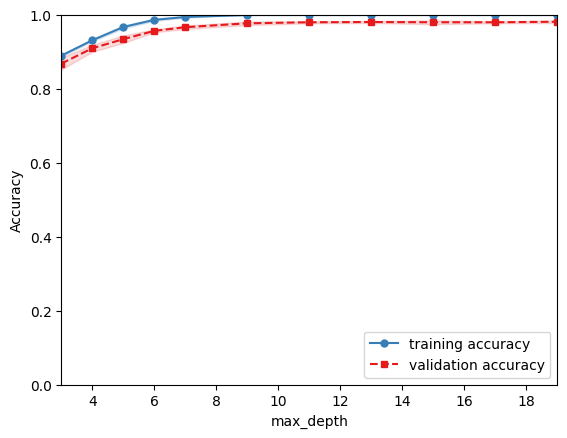

In [8]:
plot_validation_curve(train_scores, test_scores, max_depths, xlabel='max_depth')
plt.xlim(3, 19)
plt.ylim(0, 1)

0.9894440534834623
0.9894440534834623
0.9490968801313628
0.9490968801313628
[[118   1   0   0   3]
 [  7 111   1   0   3]
 [  1   0 120   0   1]
 [  5   1   2 113   0]
 [  1   5   0   0 116]] 

[[0.96721311 0.00819672 0.         0.         0.02459016]
 [0.05737705 0.90983606 0.00819672 0.         0.02459016]
 [0.00819672 0.         0.98360656 0.         0.00819672]
 [0.04132231 0.00826446 0.01652893 0.9338843  0.        ]
 [0.00819672 0.04098361 0.         0.         0.95081967]] 

[[0.96721311 0.00819672 0.         0.         0.02459016]
 [0.05737705 0.90983606 0.00819672 0.         0.02459016]
 [0.00819672 0.         0.98360656 0.         0.00819672]
 [0.04132231 0.00826446 0.01652893 0.9338843  0.        ]
 [0.00819672 0.04098361 0.         0.         0.95081967]]


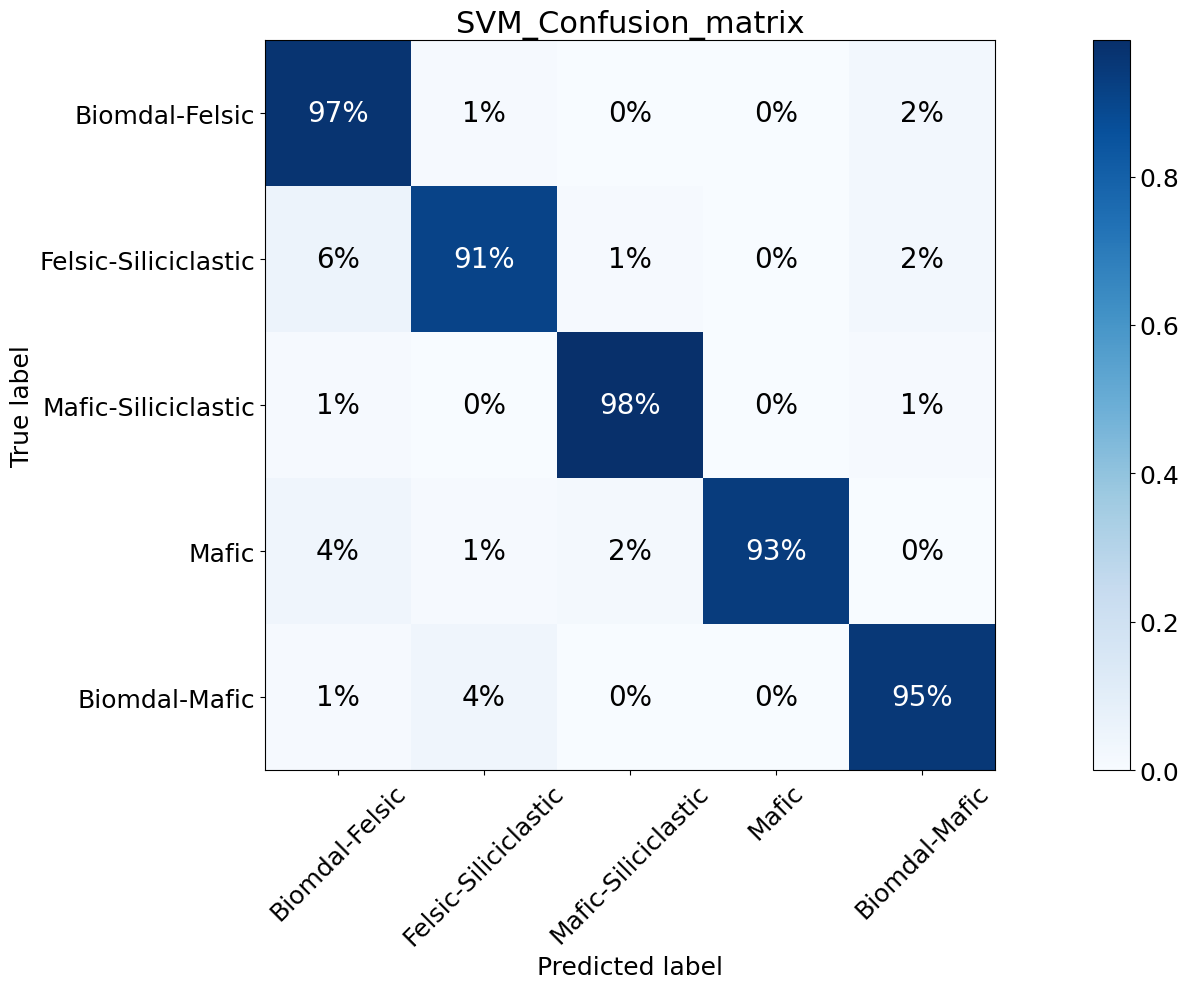

In [9]:
# plt.savefig(validation_curve_path, bbox_inches='tight', dpi=300)
np.random.seed(1)

clf=svm.SVC(kernel='linear',C=0.5,gamma = 1e-4)
# clf.fit(X_train, Y_train)

# pred = clf.predict(X_test)
# 训练集评分
print(clf.score(X=X_train, y=Y_train))
print(metrics.accuracy_score(y_true=Y_train, y_pred=clf.predict(X_train)))
# 测试集评分
print(clf.score(X_test, Y_test))
print(metrics.accuracy_score(Y_test,pred))

#scores = cross_val_class_score(clf, X_train, Y_train)
cmat = confusion_matrix(Y_test, pred)
columns=["Biomdal-Felsic",
"Felsic-Siliciclastic",
"Mafic-Siliciclastic",
"Mafic",
"Biomdal-Mafic"
]
index =  [0,1,2,3,4]
plot_matrix(Y_test, pred,index, title='SVM_Confusion_matrix',
                    axis_labels=columns)

#print('accuracy {} +/- {}'.format(scores.mean(axis=0), scores.std(axis=0))) 
# boxplot
# data=pd.DataFrame(scores, columns=["a","b"])
# display(data)
# sns.boxplot(data=pd.DataFrame(scores, columns=["a","b"]), palette=sns.color_palette('Set1'))
# plt.xlabel('Left')
# plt.ylabel('accuracy')
# plt.show()

#### from sklearn.metrics import accuracy_score # 引入准确度评分函数
y_pred = clf.predict(X_test)
print('训练集模型分数:', clf.score(X_train,Y_train))
print('测试集模型分数:', clf.score(X_test,Y_test))
print("训练集准确率: %.3f" % accuracy_score(Y_train, clf.predict(X_train)))
print("测试集准确率: %.3f" % accuracy_score(Y_test, y_pred))

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 计算精确度
precision = precision_score(Y_test, pred, average='macro')
print(f'Precision: {precision}')

# 计算召回率
recall = recall_score(Y_test, pred, average='macro')
print(f'Recall: {recall}')

# 计算 F1 分数
f1 = f1_score(Y_test, pred, average='macro')
print(f'F1 Score: {f1}')


Precision: 0.9506633094065918
Recall: 0.9490719414713453
F1 Score: 0.9492952872649161


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
cm = confusion_matrix(Y_test, pred)
num_classes = len(np.unique(Y_test))

for i in range(num_classes):
    precision_i = cm[i][i]/sum([cm[j][i] for j in range(num_classes)])
    recall_i = cm[i][i]/sum([cm[i][j] for j in range(num_classes)])
    f1_i = 2 * (precision_i * recall_i)/(precision_i + recall_i)
    print(f"类别 {columns[i]} 的Precision: {precision_i:.4f}")
    print(f"类别 {columns[i]} 的Recall: {recall_i:.4f}")
    print(f"类别 {columns[i]} 的F1-score: {f1_i:.4f}")

类别 Biomdal-Felsic 的Precision: 0.8939
类别 Biomdal-Felsic 的Recall: 0.9672
类别 Biomdal-Felsic 的F1-score: 0.9291
类别 Felsic-Siliciclastic 的Precision: 0.9407
类别 Felsic-Siliciclastic 的Recall: 0.9098
类别 Felsic-Siliciclastic 的F1-score: 0.9250
类别 Mafic-Siliciclastic 的Precision: 0.9756
类别 Mafic-Siliciclastic 的Recall: 0.9836
类别 Mafic-Siliciclastic 的F1-score: 0.9796
类别 Mafic 的Precision: 1.0000
类别 Mafic 的Recall: 0.9339
类别 Mafic 的F1-score: 0.9658
类别 Biomdal-Mafic 的Precision: 0.9431
类别 Biomdal-Mafic 的Recall: 0.9508
类别 Biomdal-Mafic 的F1-score: 0.9469
